<a href="https://colab.research.google.com/github/madhugoutham/Enhanced-Image-Classification-for-Unseen-Class-Detection/blob/main/AML644.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tensorflow scikit-learn tqdm matplotlib seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive



# Section 1: Imports and Configuration


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.utils import class_weight
from tqdm import tqdm
import random
import logging
from dataclasses import dataclass
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress TensorFlow warnings
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print(f'TensorFlow Version: {tf.__version__}')

# Check for GPU availability
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f'Using device: {device}')

TensorFlow Version: 2.17.1
Using device: /GPU:0


# Section 2: Configuration Dataclass

In [ ]:
@dataclass
class ModelConfig:
    """Configuration for the ZSL model."""
    noise_dim: int = 128
    batch_size: int = 64
    epochs: int = 20  # For classifiers
    gan_epochs: int = 200  # Increased epochs for GAN training
    learning_rate: float = 1e-4
    beta: float = 0.01
    lambda_gp: float = 10.0
    n_critic: int = 5
    img_size: Tuple[int, int] = (224, 224)
    num_total_classes: int = 200  # Total classes (seen + unseen)
    num_seen_classes: int = 150
    clip_value: float = 0.01
    n_samples_per_class: int = 1000  # Increased synthetic samples per class
    features_dir: str = 'features'  # Directory to save/load features

config = ModelConfig()

# Section 3: Data Processing

In [ ]:
class DataProcessor:
    """Handles data loading and preprocessing."""

    def __init__(self, config: ModelConfig):
        self.config = config
        self.device = device

    def load_attributes(self, attributes_folder: str, attributes_file: str,
                        class_attr_file: str):
        """Load and process attributes."""
        attributes_file_path = os.path.join(attributes_folder, attributes_file)
        class_attr_file_path = os.path.join(attributes_folder, class_attr_file)

        # Load attribute names
        with open(attributes_file_path, 'r') as f:
            attribute_names = [line.strip() for line in f]

        # Load class attributes
        attributes = np.loadtxt(class_attr_file_path)
        print(f'Attributes shape: {attributes.shape}')
        return attributes, attribute_names

    def get_image_paths_and_labels(self, data_dir: str):
        """Get image paths and labels."""
        image_dir = os.path.join(data_dir, 'images')
        classes = sorted(os.listdir(image_dir))
        class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        image_paths = []
        labels = []
        for cls_name in classes:
            cls_dir = os.path.join(image_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(cls_dir, img_name))
                    labels.append(class_to_idx[cls_name])
        return image_paths, labels, class_to_idx

    def extract_features(self, image_paths: List[str]):
        """Extract features using ResNet-101."""
        base_model = keras.applications.ResNet101(
            weights='imagenet',
            include_top=False,
            pooling='avg',
            input_shape=self.config.img_size + (3,)
        )
        features = []
        for img_path in tqdm(image_paths, desc='Extracting features'):
            img = self._load_and_preprocess_image(img_path)
            img = tf.expand_dims(img, 0)
            with tf.device(self.device):
                feature = base_model(img)
            features.append(feature.numpy()[0])
        return np.array(features, dtype='float32')  # Ensure float32

    def _load_and_preprocess_image(self, img_path: str):
        """Load and preprocess a single image."""
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, self.config.img_size)
        img = keras.applications.resnet.preprocess_input(img)
        return img

# Section 4: Model Architecture

In [ ]:
class ModelBuilder:
    """Handles building the generator, discriminator, and classifiers."""

    @staticmethod
    def build_generator(noise_dim: int, attr_dim: int, feature_dim: int) -> keras.Model:
        """Build the generator model."""
        noise_input = layers.Input(shape=(noise_dim,), dtype='float32')
        attr_input = layers.Input(shape=(attr_dim,), dtype='float32')
        x = layers.Concatenate()([noise_input, attr_input])
        x = layers.Dense(4096, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(4096, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(feature_dim, activation='tanh')(x)
        return keras.Model(inputs=[noise_input, attr_input], outputs=x, name='generator')

    @staticmethod
    def build_discriminator(feature_dim: int, attr_dim: int) -> keras.Model:
        """Build the discriminator model without spectral normalization."""
        feature_input = layers.Input(shape=(feature_dim,), dtype='float32')
        attr_input = layers.Input(shape=(attr_dim,), dtype='float32')
        x = layers.Concatenate()([feature_input, attr_input])

        # Standard layers with layer normalization
        x = layers.Dense(2048)(x)
        x = layers.LayerNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(1024)(x)
        x = layers.LayerNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(1)(x)  # Linear output for WGAN
        return keras.Model(inputs=[feature_input, attr_input], outputs=x, name='discriminator')

    @staticmethod
    def build_classifier(feature_dim: int, num_classes: int) -> keras.Model:
        """Build the One-vs-All classifier model."""
        inputs = layers.Input(shape=(feature_dim,), dtype='float32')
        x = layers.Dense(1024, activation='relu')(inputs)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        outputs = layers.Dense(num_classes, activation='sigmoid')(x)
        return keras.Model(inputs=inputs, outputs=outputs, name='one_vs_all_classifier')

# Section 5: WGAN-GP Implementation

In [ ]:
class WGAN_GP(keras.Model):
    """Wasserstein GAN with Gradient Penalty."""

    def __init__(self, generator, discriminator, config: ModelConfig):
        super(WGAN_GP, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.config = config
        self.gp_weight = config.lambda_gp
        self.cls_weight = config.beta
        self.n_critic = config.n_critic

        # Use RMSprop optimizer for WGAN-GP
        self.d_optimizer = keras.optimizers.RMSprop(learning_rate=5e-5)
        self.g_optimizer = keras.optimizers.RMSprop(learning_rate=5e-5)

        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')

    def compile(self, classifier):
        super(WGAN_GP, self).compile()
        self.classifier = classifier
        self.c_loss_fn = keras.losses.BinaryCrossentropy()

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def _gradient_penalty(self, real_samples, fake_samples, attrs):
        """Calculate gradient penalty."""
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
        interpolated = alpha * real_samples + (1 - alpha) * fake_samples

        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            validity_interpolated = self.discriminator([interpolated, attrs], training=True)

        gradients = tape.gradient(validity_interpolated, [interpolated])[0]
        gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1) + 1e-12)
        gp = tf.reduce_mean((gradients_norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        """Perform a single training step."""
        real_features, labels, attrs = data
        batch_size = tf.shape(real_features)[0]

        # Train Discriminator
        for _ in range(self.n_critic):
            noise = tf.random.normal([batch_size, self.config.noise_dim])
            with tf.GradientTape() as tape:
                fake_features = self.generator([noise, attrs], training=True)
                real_validity = self.discriminator([real_features, attrs], training=True)
                fake_validity = self.discriminator([fake_features, attrs], training=True)

                # WGAN loss
                d_loss = tf.reduce_mean(fake_validity) - tf.reduce_mean(real_validity)

                # Gradient penalty
                gp = self._gradient_penalty(real_features, fake_features, attrs)
                d_loss += self.gp_weight * gp

            grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Train Generator
        noise = tf.random.normal([batch_size, self.config.noise_dim])
        with tf.GradientTape() as tape:
            fake_features = self.generator([noise, attrs], training=True)
            fake_validity = self.discriminator([fake_features, attrs], training=True)

            # Generator adversarial loss
            g_loss_adv = -tf.reduce_mean(fake_validity)

            # Classification loss
            class_logits = self.classifier(fake_features, training=False)
            cls_loss = self.c_loss_fn(labels, class_logits)

            # Total generator loss
            g_loss = g_loss_adv + self.cls_weight * cls_loss

        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

# Section 6: Training and Evaluation Functions

In [ ]:
def create_gan_dataset(features, labels, attrs, batch_size):
    """Create TensorFlow dataset for GAN training."""
    dataset = tf.data.Dataset.from_tensor_slices((features, labels, attrs))
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def generate_synthetic_features(generator, unseen_classes, attributes,
                                n_samples_per_class, noise_dim):
    """Generate synthetic features for unseen classes."""
    synthetic_features = []
    synthetic_labels = []

    for unseen_class in unseen_classes:
        attr = attributes[unseen_class]
        attr = np.tile(attr, (n_samples_per_class, 1)).astype('float32')
        noise = np.random.normal(0, 1, (n_samples_per_class, noise_dim)).astype('float32')
        gen_features = generator.predict([noise, attr], verbose=0)
        # Add Gaussian noise and data augmentation
        gen_features += np.random.normal(0, 0.1, gen_features.shape).astype('float32')
        # Apply feature-level data augmentation
        gen_features = feature_augmentation(gen_features)
        synthetic_features.append(gen_features)
        synthetic_labels.extend([unseen_class] * n_samples_per_class)

    synthetic_features = np.vstack(synthetic_features).astype('float32')
    synthetic_labels = np.array(synthetic_labels)
    return synthetic_features, synthetic_labels

def feature_augmentation(features):
    """Apply feature-level data augmentation."""
    # For example, add random noise
    augmented_features = features + np.random.normal(0, 0.05, features.shape).astype('float32')
    return augmented_features

def one_vs_all_classification(test_features, classifier, unseen_class_indices):
    """Perform One-vs-All classification for unseen classes."""
    # Predict probabilities for all classes
    probabilities = classifier.predict(test_features)
    # Select only the probabilities for unseen classes
    unseen_probabilities = probabilities[:, unseen_class_indices]
    # Assign each sample to the unseen class with the highest probability
    predicted_labels = np.argmax(unseen_probabilities, axis=1)
    return predicted_labels

def plot_synthetic_features(real_unseen_features, synthetic_features, test_labels_encoded, synthetic_labels_encoded):
    """Visualize synthetic and real unseen features using t-SNE."""
    tsne = TSNE(n_components=2, random_state=42)
    combined_features = np.vstack([real_unseen_features, synthetic_features])
    combined_features_2d = tsne.fit_transform(combined_features)
    combined_labels = np.concatenate([test_labels_encoded, synthetic_labels_encoded + np.max(test_labels_encoded) + 1])

    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x=combined_features_2d[:, 0],
        y=combined_features_2d[:, 1],
        hue=combined_labels,
        palette='tab20',
        legend='full',
        alpha=0.7
    )
    plt.title('t-SNE Visualization of Real Unseen and Synthetic Features')
    plt.legend([], [], frameon=False)
    plt.show()

def plot_training_history(history, title_suffix=''):
    """Plot training loss and accuracy."""
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_gan_loss(wgan_history):
    """Plot GAN loss curves."""
    plt.figure(figsize=(12, 5))

    # Plot Discriminator Loss
    plt.subplot(1, 2, 1)
    plt.plot(wgan_history.history['d_loss'], label='Discriminator Loss')
    plt.title('WGAN-GP Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Generator Loss
    plt.subplot(1, 2, 2)
    plt.plot(wgan_history.history['g_loss'], label='Generator Loss')
    plt.title('WGAN-GP Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_performance_comparison(methods, accuracies):
    """Plot a bar chart comparing different classification methods."""
    plt.figure(figsize=(8, 6))
    sns.barplot(x=methods, y=accuracies, palette='viridis')
    plt.title('Comparison of Classification Approaches')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Methods')
    plt.ylim(0, 100)
    plt.legend([], [], frameon=False)  # Hide legend
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 1, f"{acc:.2f}%", ha='center')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    """Plot confusion matrix using seaborn heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(20, 16))
    sns.heatmap(cm_normalized, annot=False, cmap='Blues', fmt='.2f',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

def plot_sample_predictions(image_paths, predicted_labels, true_labels, original_class_idx_to_class_name, unseen_classes, num_samples=5):
    """Plot sample images with predicted and true labels."""
    selected_indices = random.sample(range(len(image_paths)), num_samples)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        img_path = image_paths[idx]
        img = keras.preprocessing.image.load_img(img_path, target_size=config.img_size)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize for display

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img.astype('float32'))
        plt.axis('off')

        # true_labels maps to 0-(num_unseen_classes-1), so map back to original class index
        original_true_class_idx = unseen_classes[true_labels[idx]]
        true_class = original_class_idx_to_class_name[original_true_class_idx]

        # predicted_labels maps to 0-(num_unseen_classes-1), so map back to original class index
        original_pred_class_idx = unseen_classes[predicted_labels[idx]]
        pred_class = original_class_idx_to_class_name[original_pred_class_idx]

        plt.title(f"True: {true_class}\nPred: {pred_class}")
    plt.show()

# Custom Focal Loss Implementation

In [ ]:
def binary_focal_loss(alpha=0.25, gamma=2.0):
    """
    Binary focal loss for multi-label classification.

    Parameters:
    - alpha: Weighting factor for the rare class.
    - gamma: Focusing parameter to reduce the relative loss for well-classified examples.

    Returns:
    - loss_fn: A loss function that can be used in model.compile()
    """
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        # Clip predictions to prevent log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        # Compute cross-entropy loss
        ce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        # Compute focal loss scaling factor
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_factor = alpha * tf.pow(1 - p_t, gamma)
        # Compute focal loss
        loss = focal_factor * ce
        # Take the mean over the batch
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# Section 7: Main Training Loop

Attributes shape: (200, 312)
Total images: 11806
Seen classes: 150
Unseen classes: 50

Loading pre-extracted features...
Seen features shape: (8849, 2048)
Unseen features shape: (2957, 2048)

Training One-vs-All classifier on seen features...
Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0050 - loss: 3.5568
Epoch 1: accuracy improved from -inf to 0.00622, saving model to /content/drive/MyDrive/pattern project/features_dir/one_vs_all_classifier.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.0050 - loss: 3.5434
Epoch 2/20
134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0146 - loss: 0.5870
Epoch 2: accuracy improved from 0.00622 to 0.02012, saving model to /content/drive/MyDrive/pattern project/features_dir/one_vs_all_classifier.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.0148 - loss: 0.5860
Epoch 3/20
121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0470 - loss: 0.4961
Epoch 3: accuracy improved from 0.02012 to 0.06780, 

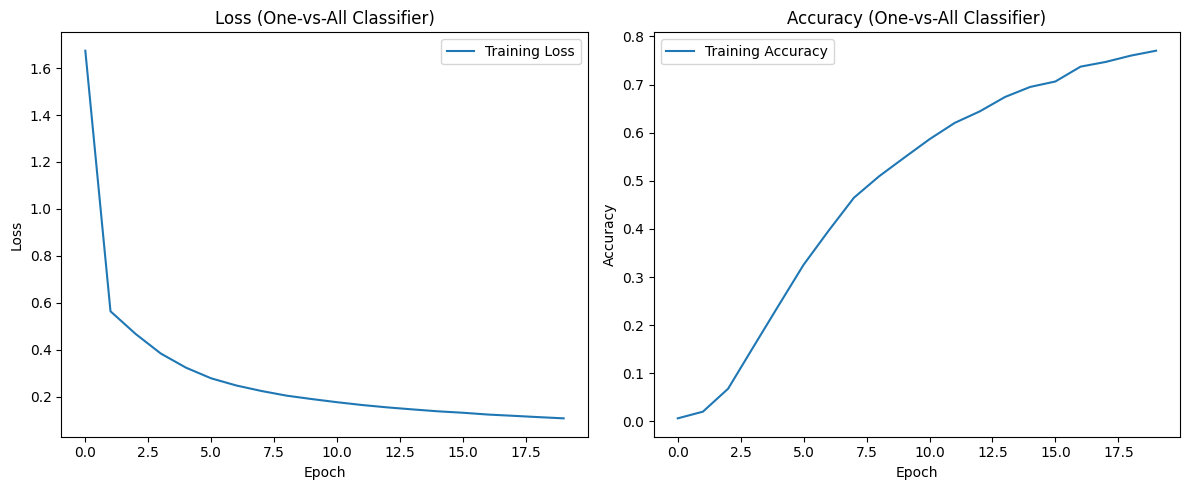


Training WGAN-GP...
Epoch 1/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 138s 396ms/step - d_loss: -4.5804 - g_loss: 1.8528
Epoch 2/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - d_loss: -15.3120 - g_loss: 4.6230
Epoch 3/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - d_loss: -14.9116 - g_loss: 3.3235
Epoch 4/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - d_loss: -14.7856 - g_loss: 2.2081
Epoch 5/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - d_loss: -14.7294 - g_loss: 1.4970
Epoch 6/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - d_loss: -14.5817 - g_loss: 0.7214
Epoch 7/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - d_loss: -14.1451 - g_loss: -0.2340
Epoch 8/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - d_loss: -12.0714 - g_loss: -2.9894
Epoch 9/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - d_loss: -5.8719 - g_loss: -9.7884
Epoch 10/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - d_loss: -3.0660 - g_loss: -12.4090
Epoch 11/200
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - d_loss: -2.2289 

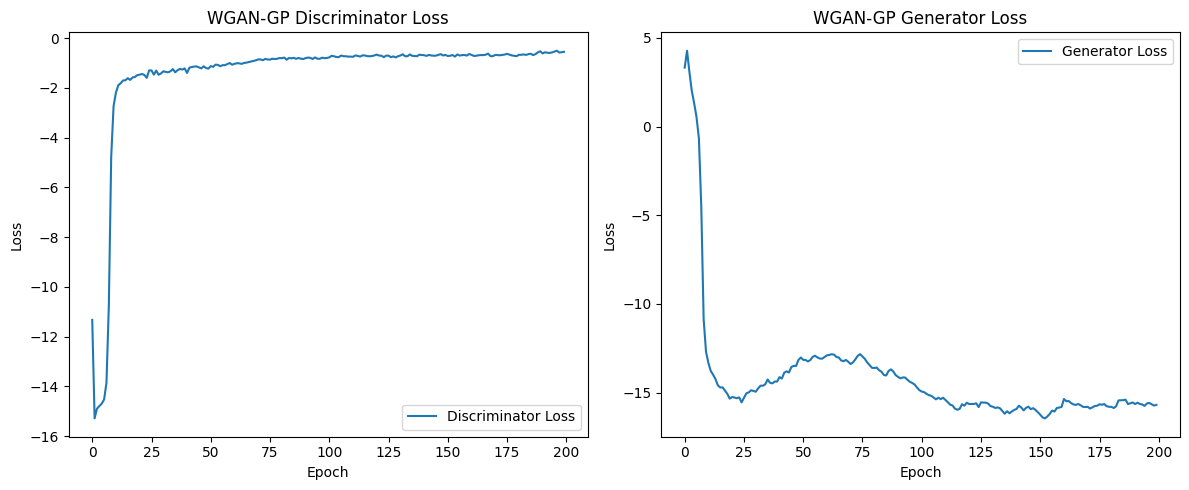


Generating synthetic features for unseen classes...
Synthetic features shape: (50000, 2048)

Synthetic features saved to disk.

Visualizing synthetic features...


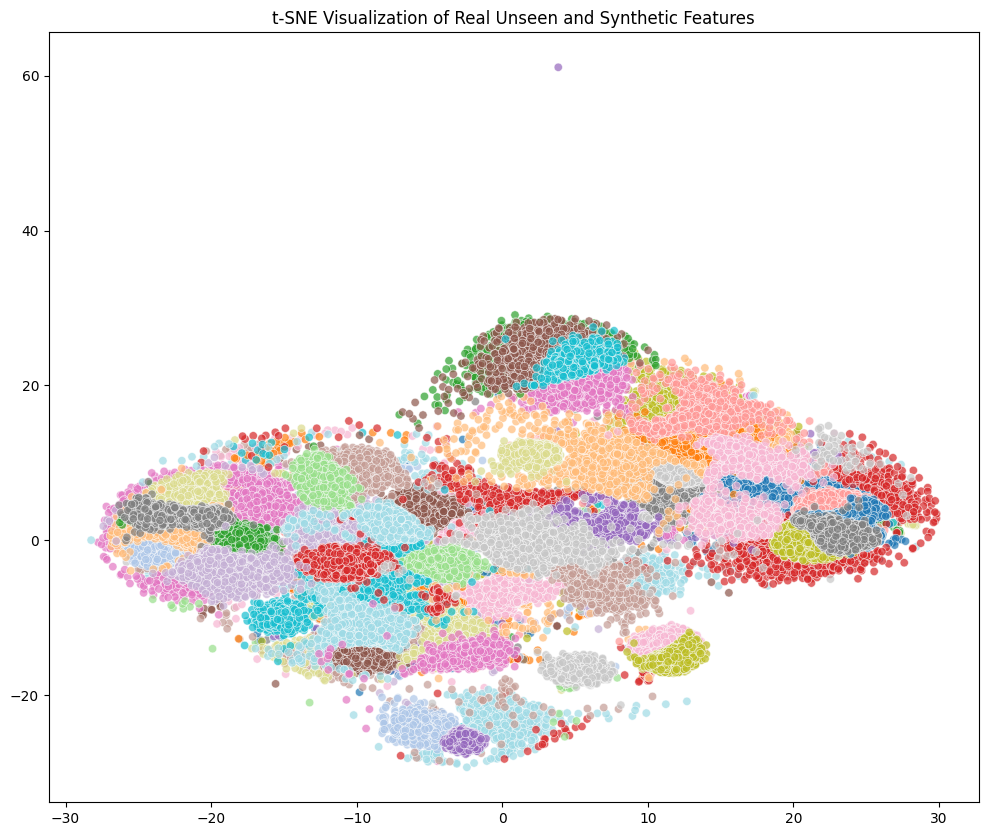


Training hybrid classifier with synthetic unseen features...
Epoch 1/20
920/920 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1547 - loss: 1.4361
Epoch 1: accuracy improved from -inf to 0.37287, saving model to /content/drive/MyDrive/pattern project/features_dir/hybrid_classifier.keras
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.1549 - loss: 1.4352
Epoch 2/20
910/920 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7813 - loss: 0.1405
Epoch 2: accuracy improved from 0.37287 to 0.81514, saving model to /content/drive/MyDrive/pattern project/features_dir/hybrid_classifier.keras
920/920 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7817 - loss: 0.1402
Epoch 3/20
914/920 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8711 - loss: 0.0708
Epoch 3: accuracy improved from 0.81514 to 0.88323, saving model to /content/drive/MyDrive/pattern project/features_dir/hybrid_classifier.keras
920/920 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8712 - loss: 0.0707
Epoch 4/20
912/920 ━━━━━━━

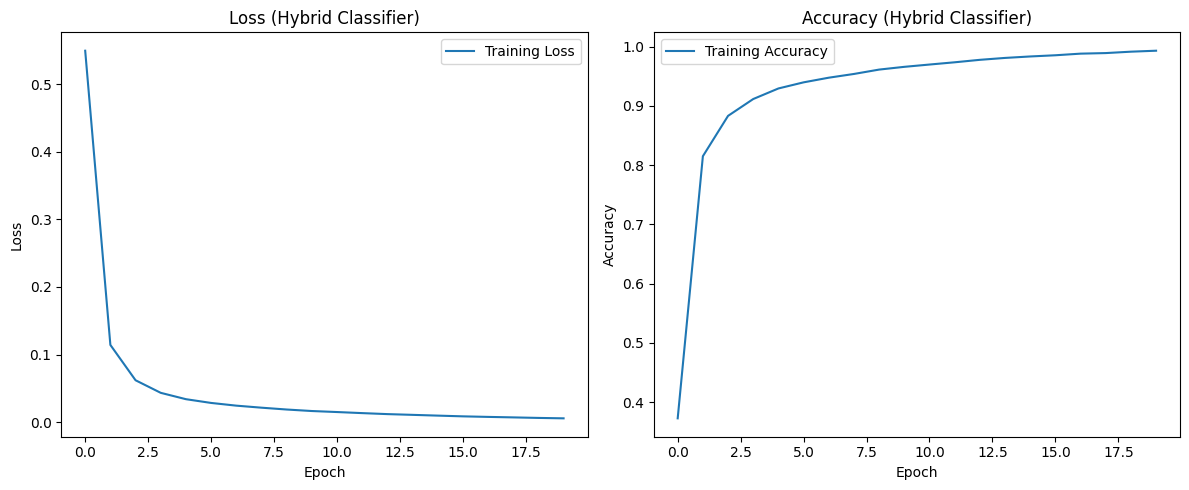


Training attribute mapping model...
Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.4544
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0815
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0459
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0356
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0276
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0254
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0238
Epoch 9/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0224
Epoch 10/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0213
Epoch 11/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0203
Epoch 12/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0194
Epoch 13/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0185
Epoch 14/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0177
Epoch 15/20
139/139

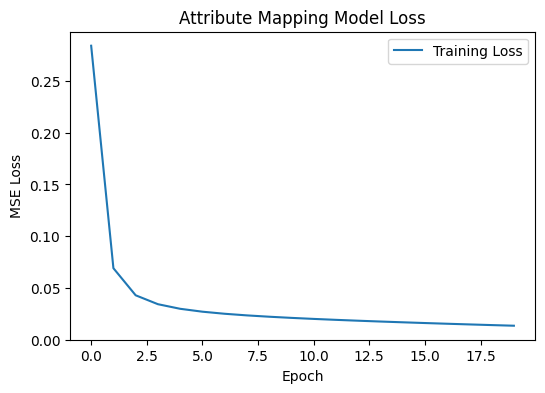


Evaluating all methods...

Evaluating Hybrid Classifier...
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Hybrid Classifier Accuracy on Unseen Classes: 47.31%

Evaluating Zero-Shot Learning (Attribute-Based) Classifier...
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Zero-Shot Learning Accuracy on Unseen Classes: 35.04%

Comparison of Zero-Shot Learning and Hybrid Classifier:


<ipython-input-17-ee67e693ce27>:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=accuracies, palette='viridis')


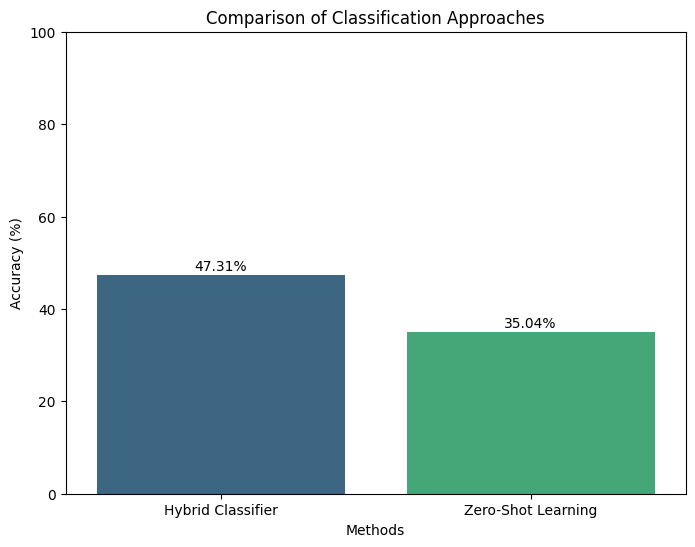


Detailed Classification Report (Hybrid Classifier):
              precision    recall  f1-score   support

   Class 137       0.51      0.47      0.49        60
   Class 117       0.21      0.12      0.15        60
    Class 11       0.75      0.75      0.75        56
    Class 67       0.78      0.63      0.70        60
    Class 88       0.40      0.57      0.47        60
    Class 91       0.91      0.52      0.66        60
    Class 24       0.05      0.03      0.04        61
    Class 97       0.52      0.42      0.46        60
   Class 182       0.87      0.80      0.83        60
   Class 190       0.73      0.60      0.66        60
    Class 86       0.49      0.77      0.60        61
   Class 181       0.72      0.70      0.71        60
    Class 39       0.34      0.37      0.35        60
   Class 168       0.48      0.58      0.52        59
    Class 87       0.76      0.53      0.63        60
   Class 185       0.62      0.85      0.72        60
    Class 40       0.23     

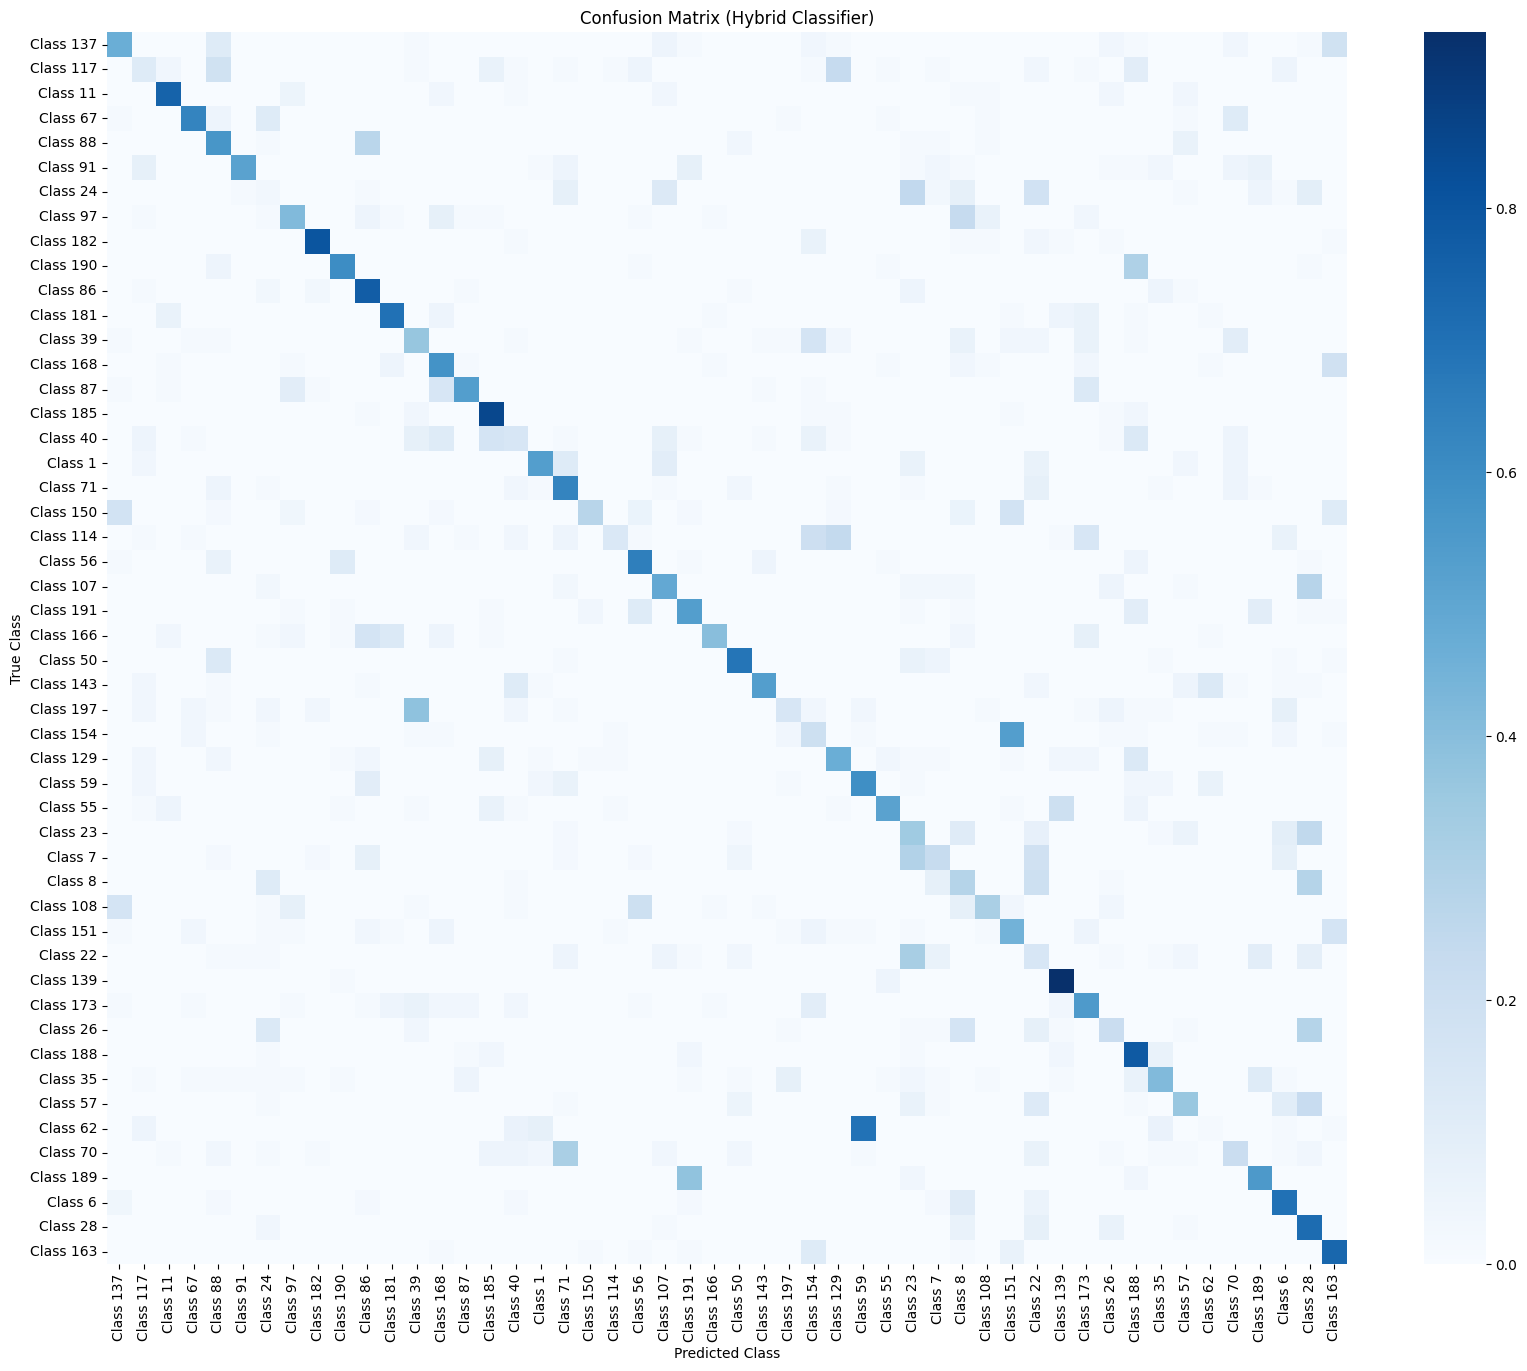


Plotting Sample Predictions...


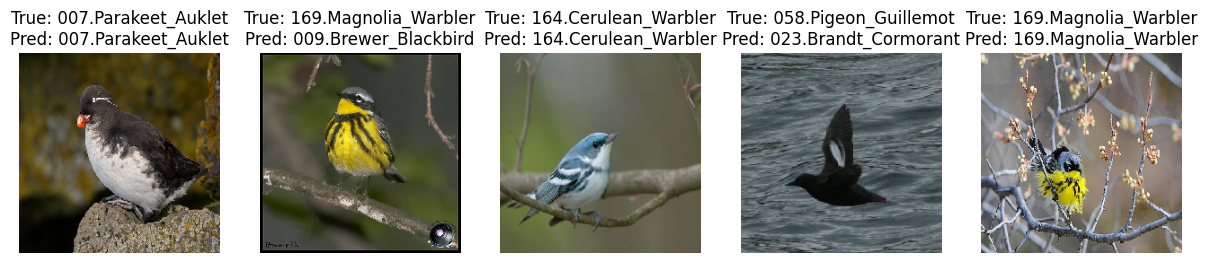

In [ ]:
def main():
    """Main execution function."""
    try:
        # Initialize data processor
        data_processor = DataProcessor(config)

        # Define paths (adjust paths according to your environment)
        data_dir = '/content/drive/MyDrive/pattern project/CUB_200_2011'  # <-- Adjust this path
        attributes_folder = os.path.join(data_dir, 'attributes')
        attributes_file = 'attributes.txt'
        class_attr_file = 'class_attribute_labels_continuous.txt'

        # Load attributes
        attributes, attribute_names = data_processor.load_attributes(
            attributes_folder, attributes_file, class_attr_file
        )

        # Load image paths and labels
        image_paths, labels, class_to_idx = data_processor.get_image_paths_and_labels(
            data_dir
        )
        print(f'Total images: {len(image_paths)}')

        # Select classes for seen/unseen split
        all_classes = list(range(200))
        random.shuffle(all_classes)
        selected_classes = all_classes[:config.num_total_classes]

        # Split into seen and unseen classes
        seen_classes = selected_classes[:config.num_seen_classes]
        unseen_classes = selected_classes[config.num_seen_classes:]
        print(f'Seen classes: {len(seen_classes)}')
        print(f'Unseen classes: {len(unseen_classes)}')

        # Filter data for seen and unseen classes
        seen_indices = [i for i, label in enumerate(labels) if label in seen_classes]
        seen_image_paths = [image_paths[i] for i in seen_indices]
        seen_labels = [labels[i] for i in seen_indices]

        unseen_indices = [i for i, label in enumerate(labels) if label in unseen_classes]
        unseen_image_paths = [image_paths[i] for i in unseen_indices]
        unseen_labels = [labels[i] for i in unseen_indices]

        # Create features directory if it doesn't exist
        features_dir = "/content/drive/MyDrive/pattern project/features_dir"
        if not os.path.exists(features_dir):
            os.makedirs(features_dir)

        # Define feature file paths
        seen_features_path = os.path.join(features_dir, 'seen_features.npy')
        unseen_features_path = os.path.join(features_dir, 'unseen_features.npy')

        # Check if features are already extracted and saved
        if os.path.exists(seen_features_path) and os.path.exists(unseen_features_path):
            print("\nLoading pre-extracted features...")
            seen_features = np.load(seen_features_path).astype('float32')
            unseen_features = np.load(unseen_features_path).astype('float32')
            print(f'Seen features shape: {seen_features.shape}')
            print(f'Unseen features shape: {unseen_features.shape}')
        else:
            # Extract features and save them
            print("\nExtracting features for seen classes...")
            seen_features = data_processor.extract_features(seen_image_paths)
            print(f'Seen features shape: {seen_features.shape}')

            print("\nExtracting features for unseen classes...")
            unseen_features = data_processor.extract_features(unseen_image_paths)
            print(f'Unseen features shape: {unseen_features.shape}')

            # Save extracted features
            np.save(seen_features_path, seen_features)
            np.save(unseen_features_path, unseen_features)
            print("\nFeatures saved to disk.")

        # Normalize features
        feature_scaler = MinMaxScaler()
        all_features = np.concatenate([seen_features, unseen_features], axis=0)
        feature_scaler.fit(all_features)
        seen_features = feature_scaler.transform(seen_features).astype('float32')
        unseen_features = feature_scaler.transform(unseen_features).astype('float32')

        # Normalize attributes
        attr_scaler = MinMaxScaler()
        attributes = attr_scaler.fit_transform(attributes).astype('float32')

        # Prepare attributes for seen and unseen classes
        seen_attributes = np.array([attributes[label] for label in seen_labels], dtype='float32')
        unseen_attributes = np.array([attributes[label] for label in unseen_labels], dtype='float32')

        # Create mapping from original class indices to new indices
        all_class_to_idx = {original_cls: idx for idx, original_cls in enumerate(selected_classes)}
        idx_to_class = {idx: original_cls for idx, original_cls in enumerate(selected_classes)}

        # Map seen_labels to new indices
        seen_labels_encoded = np.array([all_class_to_idx[label] for label in seen_labels], dtype='int32')
        # Create multi-hot labels for One-vs-All
        seen_labels_multi_hot = np.zeros((len(seen_labels_encoded), config.num_total_classes), dtype='float32')
        seen_labels_multi_hot[np.arange(len(seen_labels_encoded)), seen_labels_encoded] = 1.0

        # Build models
        model_builder = ModelBuilder()
        feature_dim = seen_features.shape[1]
        attr_dim = attributes.shape[1]
        num_total_classes = len(selected_classes)

        # Build and compile One-vs-All classifier with Custom Focal Loss
        classifier = model_builder.build_classifier(feature_dim, num_total_classes)
        classifier.compile(
            optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
            loss=binary_focal_loss(alpha=0.25, gamma=2.0),  # Using custom focal loss
            metrics=['accuracy']
        )

        # Model checkpoint for classifier
        classifier_checkpoint_path = os.path.join(features_dir, 'one_vs_all_classifier.keras')
        classifier_checkpoint = keras.callbacks.ModelCheckpoint(
            classifier_checkpoint_path,
            monitor='accuracy',
            verbose=1,
            save_best_only=True,
            mode='max'
        )
        classifier_early_stopping = keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=10,
            restore_best_weights=True
        )

        # Compute class weights
        y_integers = np.argmax(seen_labels_multi_hot, axis=1)
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_integers),
            y=y_integers
        )
        class_weight_dict = dict(enumerate(class_weights))

        # Train classifier on real seen features
        print("\nTraining One-vs-All classifier on seen features...")
        classifier_history = classifier.fit(
            seen_features,
            seen_labels_multi_hot,
            epochs=config.epochs,
            batch_size=config.batch_size,
            verbose=1,
            callbacks=[classifier_checkpoint, classifier_early_stopping],
            class_weight=class_weight_dict
        )

        # Plot training history for classifier
        plot_training_history(classifier_history, title_suffix='(One-vs-All Classifier)')

        # Build generator and discriminator
        generator = model_builder.build_generator(config.noise_dim, attr_dim, feature_dim)
        discriminator = model_builder.build_discriminator(feature_dim, attr_dim)

        # Create and train WGAN-GP
        print("\nTraining WGAN-GP...")
        gan_dataset = create_gan_dataset(
            seen_features,
            seen_labels_multi_hot,
            seen_attributes,
            config.batch_size
        )

        wgan = WGAN_GP(generator, discriminator, config)
        wgan.compile(classifier=classifier)

        # WGAN-GP training
        wgan_history = wgan.fit(gan_dataset, epochs=config.gan_epochs, verbose=1)

        # Plot GAN loss curves
        plot_gan_loss(wgan_history)

        # Generate synthetic features for unseen classes
        print("\nGenerating synthetic features for unseen classes...")
        synthetic_features, synthetic_labels = generate_synthetic_features(
            generator,
            unseen_classes,
            attributes,
            config.n_samples_per_class,
            config.noise_dim
        )
        print(f'Synthetic features shape: {synthetic_features.shape}')

        # Save synthetic features
        synthetic_features_path = os.path.join(features_dir, 'synthetic_features.npy')
        synthetic_labels_path = os.path.join(features_dir, 'synthetic_labels.npy')
        np.save(synthetic_features_path, synthetic_features)
        np.save(synthetic_labels_path, synthetic_labels)
        print("\nSynthetic features saved to disk.")

        # Create multi-hot labels for synthetic data
        synthetic_labels_encoded = np.array([all_class_to_idx[label] for label in synthetic_labels], dtype='int32')
        synthetic_labels_multi_hot = np.zeros((len(synthetic_labels_encoded), config.num_total_classes), dtype='float32')
        synthetic_labels_multi_hot[np.arange(len(synthetic_labels_encoded)), synthetic_labels_encoded] = 1.0

        # Visualize synthetic features
        print("\nVisualizing synthetic features...")
        test_labels_encoded = np.array([all_class_to_idx[label] for label in unseen_labels], dtype='int32')
        label_map = {original_cls: idx for idx, original_cls in enumerate(unseen_classes)}
        test_labels_mapped = np.array([label_map[label] for label in unseen_labels], dtype='int32')
        synthetic_labels_mapped = np.array([label_map[label] for label in synthetic_labels], dtype='int32')

        plot_synthetic_features(unseen_features, synthetic_features, test_labels_mapped, synthetic_labels_mapped)

        # Combine real seen features and synthetic unseen features
        hybrid_features = np.concatenate([seen_features, synthetic_features], axis=0).astype('float32')
        hybrid_labels_multi_hot = np.concatenate([seen_labels_multi_hot, synthetic_labels_multi_hot], axis=0).astype('float32')

        # Compute class weights for hybrid dataset
        y_integers_hybrid = np.argmax(hybrid_labels_multi_hot, axis=1)
        class_weights_hybrid = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_integers_hybrid),
            y=y_integers_hybrid
        )
        class_weight_hybrid_dict = dict(enumerate(class_weights_hybrid))

        # Build and compile hybrid classifier with Custom Focal Loss
        hybrid_classifier = model_builder.build_classifier(feature_dim, num_total_classes)
        hybrid_classifier.compile(
            optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
            loss=binary_focal_loss(alpha=0.25, gamma=2.0),  # Using custom focal loss
            metrics=['accuracy']
        )

        # Model checkpoint for hybrid classifier
        hybrid_checkpoint_path = os.path.join(features_dir, 'hybrid_classifier.keras')
        hybrid_checkpoint = keras.callbacks.ModelCheckpoint(
            hybrid_checkpoint_path,
            monitor='accuracy',
            verbose=1,
            save_best_only=True,
            mode='max'
        )
        hybrid_early_stopping = keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=10,
            restore_best_weights=True
        )

        # Train hybrid classifier
        print("\nTraining hybrid classifier with synthetic unseen features...")
        hybrid_history = hybrid_classifier.fit(
            hybrid_features,
            hybrid_labels_multi_hot,
            epochs=config.epochs,
            batch_size=config.batch_size,
            verbose=1,
            callbacks=[hybrid_checkpoint, hybrid_early_stopping],
            class_weight=class_weight_hybrid_dict
        )

        # Plot training history for hybrid classifier
        plot_training_history(hybrid_history, title_suffix='(Hybrid Classifier)')

        # Enhanced Attribute Mapping Model
        print("\nTraining attribute mapping model...")
        # Map features to attributes using a deeper neural network
        attr_mapping_model = keras.Sequential([
            layers.Input(shape=(feature_dim,)),
            layers.Dense(2048, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(1024, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(512, activation='relu'),
            layers.Dense(attr_dim)
        ])
        attr_mapping_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
            loss='mse'
        )

        attr_history = attr_mapping_model.fit(
            seen_features,
            seen_attributes,
            epochs=config.epochs,
            batch_size=config.batch_size,
            verbose=1
        )

        # Plot training history for attribute mapping model
        plt.figure(figsize=(6, 4))
        plt.plot(attr_history.history['loss'], label='Training Loss')
        if 'val_loss' in attr_history.history:
            plt.plot(attr_history.history['val_loss'], label='Validation Loss')
        plt.title('Attribute Mapping Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.legend()
        plt.show()

        # Evaluate methods
        print("\nEvaluating all methods...")

        # Create mapping from original class indices to class names
        original_class_idx_to_class_name = {idx: cls_name for cls_name, idx in class_to_idx.items()}

        # Prepare test data
        test_features = unseen_features
        test_labels = unseen_labels

        # Map labels
        unseen_class_indices = [all_class_to_idx[cls] for cls in unseen_classes]
        label_map = {original_cls: idx for idx, original_cls in enumerate(unseen_classes)}
        test_labels_encoded = np.array([label_map[label] for label in test_labels], dtype='int32')

        # 1. Hybrid Classifier Evaluation
        print("\nEvaluating Hybrid Classifier...")
        predicted_labels = one_vs_all_classification(test_features, hybrid_classifier, unseen_class_indices)
        hybrid_accuracy = accuracy_score(test_labels_encoded, predicted_labels)
        print(f'Hybrid Classifier Accuracy on Unseen Classes: {hybrid_accuracy * 100:.2f}%')

        # 2. Zero-Shot Learning Accuracy (Attribute-Based)
        print("\nEvaluating Zero-Shot Learning (Attribute-Based) Classifier...")
        # Predict attributes from test features
        predicted_attributes = attr_mapping_model.predict(test_features).astype('float32')
        # Normalize predicted attributes and class attributes
        predicted_attributes_norm = normalize(predicted_attributes).astype('float32')
        class_attributes_norm = normalize(attributes[unseen_classes]).astype('float32')
        # Compute cosine similarity
        similarities = cosine_similarity(predicted_attributes_norm, class_attributes_norm)
        # Assign each sample to the class with the highest similarity
        predicted_labels_attr = np.argmax(similarities, axis=1)
        attr_accuracy = accuracy_score(test_labels_encoded, predicted_labels_attr)
        print(f'Zero-Shot Learning Accuracy on Unseen Classes: {attr_accuracy * 100:.2f}%')

        # Compare the accuracies
        print("\nComparison of Zero-Shot Learning and Hybrid Classifier:")
        methods = ['Hybrid Classifier', 'Zero-Shot Learning']
        accuracies = [hybrid_accuracy * 100, attr_accuracy * 100]
        plot_performance_comparison(methods, accuracies)

        # Print detailed classification report for Hybrid Classifier
        print("\nDetailed Classification Report (Hybrid Classifier):")
        print(classification_report(
            test_labels_encoded,
            predicted_labels,
            target_names=[f'Class {cls}' for cls in unseen_classes],
            labels=list(range(len(unseen_classes))),
            zero_division=0  # Handle division by zero
        ))

        # Plot Confusion Matrix
        plot_confusion_matrix(
            y_true=test_labels_encoded,
            y_pred=predicted_labels,
            class_names=[f'Class {cls}' for cls in unseen_classes],
            title='Confusion Matrix (Hybrid Classifier)'
        )

        # Plot Sample Predictions
        print("\nPlotting Sample Predictions...")
        plot_sample_predictions(
            image_paths=unseen_image_paths,
            predicted_labels=predicted_labels,
            true_labels=test_labels_encoded,
            original_class_idx_to_class_name=original_class_idx_to_class_name,
            unseen_classes=unseen_classes,
            num_samples=5
        )

    except ImportError as ie:
        print(f"Import Error: {ie}")
        print("Please ensure all required packages are installed. You can install missing packages using pip.")
    except ValueError as ve:
        print(f"Value Error: {ve}")
        print("Please ensure that the dimensions of your features and attributes align correctly.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

if __name__ == "__main__":
    main()
